In [32]:
# Cell 1 - Import des bibliothèques
import os
import pydicom
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt


In [33]:
# Cell 2 - Chargement et prétraitement des DICOM
def load_dicom_files(base_dir):
    dicom_paths = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.endswith(".dcm"):
                dicom_paths.append(os.path.join(root, f))
    return dicom_paths

def preprocess_dicom(path, size=(224, 224)):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = cv2.resize(img, size)
    img = np.stack([img]*3, axis=-1)  # Convertir en 3 canaux
    return img


In [34]:
# Cell 3 - Chargement et préparation des données cliniques
xlsx_path = "CMMD/CMMD_clinicaldata_revision_sanitized.xlsx"
clinical_df = pd.read_excel(xlsx_path, sheet_name="Sheet1")
clinical_df = clinical_df.fillna("Unknown")

# Sélection des colonnes utiles
label_column = "classification"  # 'Benign' ou 'Malignant'
id_column = "ID1"

categorical_cols = clinical_df.select_dtypes(include='object').columns.drop([label_column, id_column])
numerical_cols = clinical_df.select_dtypes(include=['int64', 'float64']).columns

# Encodage des variables
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

X_cat = onehot.fit_transform(clinical_df[categorical_cols])
X_num = scaler.fit_transform(clinical_df[numerical_cols])

clinical_features = np.hstack([X_cat, X_num])
labels = clinical_df[label_column].map({"Benign": 0, "Malignant": 1}).values
patient_ids = clinical_df[id_column].values

print(f"Nombre de patients : {len(patient_ids)}")



Nombre de patients : 2333


In [35]:
# Cell 4 - Association images / patients
dicom_dir = "CMMD/manifest-1616439774456/CMMD"
dicom_paths = load_dicom_files(dicom_dir)

# Mapping patient_id → images (on suppose ../../nom_dossier = patient_id)
patient_to_images = {}
for path in dicom_paths:
    # On récupère le nom du dossier deux niveaux au-dessus
    parts = path.split(os.sep)
    if len(parts) >= 4:
        patient_id = parts[-4]
        if patient_id not in patient_to_images:
            patient_to_images[patient_id] = []
        patient_to_images[patient_id].append(path)


# Filtrer ceux qui ont bien au moins une image
filtered = [
    (pid, i, l) 
    for pid, i, l in zip(patient_ids, clinical_features, labels) 
    if pid in patient_to_images
]

print(f"{len(filtered)} patients ont à la fois des images et des données cliniques.")
print(f"{len(dicom_paths)} images au total.")
print(f"{len(patient_to_images)} patients avec au moins une image.")


2333 patients ont à la fois des images et des données cliniques.
5202 images au total.
1775 patients avec au moins une image.


In [36]:
class BreastCancerDataset(Dataset):
    def __init__(self, data, transform=None, image_size=(224, 224), max_images=4):
        self.data = data
        self.transform = transform
        self.image_size = image_size
        self.max_images = max_images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pid, clinical_vec, label = self.data[idx]
        image_paths = patient_to_images[pid]
        images = []

        # Sélectionne ou complète jusqu’à max_images
        for path in image_paths[:self.max_images]:
            img = preprocess_dicom(path, size=self.image_size)
            img = torch.tensor(img).permute(2, 0, 1).float()
            if self.transform:
                img = self.transform(img)
            images.append(img)

        # Padding si moins que max_images
        while len(images) < self.max_images:
            images.append(torch.zeros_like(images[0]))

        imgs_tensor = torch.stack(images)  # (max_images, 3, H, W)
        clinical_tensor = torch.tensor(clinical_vec).float()
        label_tensor = torch.tensor(label).long()

        return {
            "images": imgs_tensor,       # shape: (N=4, 3, 224, 224)
            "clinical": clinical_tensor, # shape: (features,)
            "label": label_tensor
        }


In [37]:
# Cell 6 - Split & DataLoader (X% du dataset)

from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Définir facilement le pourcentage à utiliser
subset_percentage = 0.99

# Calcul du test_size pour garder seulement subset_percentage
subset_splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=1 - subset_percentage,
    random_state=42
)

indices = list(range(len(filtered)))
labels_all = [x[2] for x in filtered]

for subset_idx, _ in subset_splitter.split(indices, labels_all):
    filtered_small = [filtered[i] for i in subset_idx]

print(f"Réduction à {len(filtered_small)} échantillons ({int(subset_percentage * 100)}% du total)")

# Split train/test sur ce sous-ensemble
train_data, test_data = train_test_split(
    filtered_small,
    test_size=0.2,
    random_state=42,
    stratify=[x[2] for x in filtered_small]
)

# Affichage du nombre d'éléments par classe dans chaque split
train_labels = [x[2] for x in train_data]
test_labels = [x[2] for x in test_data]

print("\nRépartition dans le jeu d'entraînement :")
for label, count in Counter(train_labels).items():
    print(f"  Classe {label} : {count} échantillons")

print("\nRépartition dans le jeu de test :")
for label, count in Counter(test_labels).items():
    print(f"  Classe {label} : {count} échantillons")

# Création des datasets et dataloaders
train_dataset = BreastCancerDataset(train_data)
test_dataset = BreastCancerDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


Réduction à 2309 échantillons (99% du total)

Répartition dans le jeu d'entraînement :
  Classe 1 : 1344 échantillons
  Classe 0 : 503 échantillons

Répartition dans le jeu de test :
  Classe 0 : 126 échantillons
  Classe 1 : 336 échantillons


In [38]:
class BreastCancerModel(nn.Module):
    def __init__(self, clinical_dim):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.fc = nn.Identity()
        self.cnn = base  # CNN sans la dernière couche (donne 512-dim)

        self.fusion = nn.Sequential(
            nn.Linear(512 + clinical_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, imgs, clinical):
        # imgs : (B, N_img, 3, H, W)
        B, N, C, H, W = imgs.shape
        imgs = imgs.view(B * N, C, H, W)
        img_feats = self.cnn(imgs)  # (B*N, 512)
        img_feats = img_feats.view(B, N, -1)  # (B, N, 512)
        img_feats = img_feats.mean(dim=1)     # (B, 512)

        x = torch.cat([img_feats, clinical], dim=1)  # (B, 512 + clinical_dim)
        return self.fusion(x)


In [39]:
# Cell 8 - Entraînement avec suivi loss et accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BreastCancerModel(clinical_dim=clinical_features.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    running_corrects = 0
    total_samples = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = batch["images"].to(device)
        clinical = batch["clinical"].to(device)
        labels = batch["label"].to(device)

        outputs = model(imgs, clinical)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)  # somme pondérée par taille batch
        preds = torch.argmax(outputs, dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 116/116 [11:32<00:00,  5.97s/it]


Epoch 1/10 - Loss: 0.5218 - Accuracy: 0.7331


Epoch 2: 100%|██████████| 116/116 [11:55<00:00,  6.17s/it]


Epoch 2/10 - Loss: 0.4115 - Accuracy: 0.7986


Epoch 3: 100%|██████████| 116/116 [11:31<00:00,  5.96s/it]


Epoch 3/10 - Loss: 0.2885 - Accuracy: 0.8722


Epoch 4: 100%|██████████| 116/116 [11:34<00:00,  5.99s/it]


Epoch 4/10 - Loss: 0.1988 - Accuracy: 0.9291


Epoch 5: 100%|██████████| 116/116 [10:33<00:00,  5.46s/it]


Epoch 5/10 - Loss: 0.1318 - Accuracy: 0.9594


Epoch 6: 100%|██████████| 116/116 [10:09<00:00,  5.25s/it]


Epoch 6/10 - Loss: 0.1225 - Accuracy: 0.9637


Epoch 7: 100%|██████████| 116/116 [10:34<00:00,  5.47s/it]


Epoch 7/10 - Loss: 0.0874 - Accuracy: 0.9751


Epoch 8: 100%|██████████| 116/116 [10:41<00:00,  5.53s/it]


Epoch 8/10 - Loss: 0.0583 - Accuracy: 0.9827


Epoch 9: 100%|██████████| 116/116 [09:32<00:00,  4.93s/it]


Epoch 9/10 - Loss: 0.0718 - Accuracy: 0.9735


Epoch 10: 100%|██████████| 116/116 [09:32<00:00,  4.94s/it]

Epoch 10/10 - Loss: 0.0562 - Accuracy: 0.9783


              precision    recall  f1-score   support

      Benign       0.69      0.63      0.66       126
   Malignant       0.86      0.89      0.88       336

    accuracy                           0.82       462
   macro avg       0.78      0.76      0.77       462
weighted avg       0.82      0.82      0.82       462



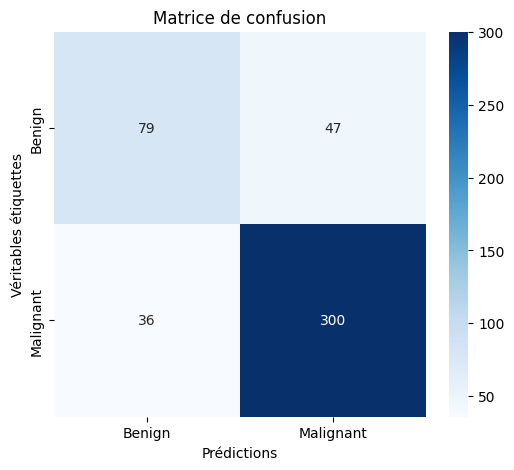

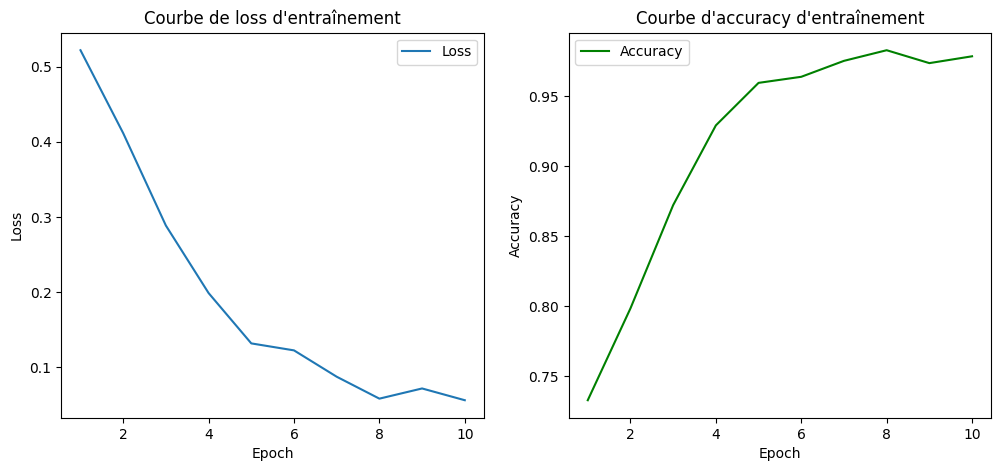

In [40]:
# Cell 9 - Évaluation avec matrice de confusion, loss et accuracy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["images"].to(device)
        clinical = batch["clinical"].to(device)
        labels = batch["label"].to(device)

        outputs = model(imgs, clinical)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport classification
print(classification_report(all_labels, all_preds, target_names=["Benign", "Malignant"]))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Prédictions")
plt.ylabel("Véritables étiquettes")
plt.title("Matrice de confusion")
plt.show()

# --- Affichage des courbes loss / accuracy (supposé stocké dans ces listes pendant l'entraînement) ---
# Ces listes doivent être mises à jour à chaque batch/epoch pendant l'entraînement

if 'train_losses' in globals() and 'train_accuracies' in globals():
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Courbe de loss d'entraînement")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'accuracy d'entraînement")
    plt.legend()

    plt.show()
else:
    print("Les listes 'train_losses' et 'train_accuracies' ne sont pas définies. Assure-toi de les mettre à jour pendant l'entraînement.")
